In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_introductory_sequence'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'
matplotlib.rcParams['font.size']=10

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']
cell_cols_d_all = prepped_data_agg['cell_cols_d_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
ani='e13_26m1'
sess='e13_26m1_210913'

In [196]:
row=subdb.iloc[15]
ani,sess = row.name[0],row['sess_name']

In [197]:
spk_beh_df = spk_beh_df_all.loc[(ani,sess),:]

/tmp/ipykernel_1190037/1635322744.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[(ani,sess),:]


In [198]:
cell_cols_d = cell_cols_d_all[ani,sess]
cell_cols_pyr=cell_cols_d['pyr']
cell_cols_int=cell_cols_d['int']

# get activity

In [6]:
def get_activity_per_trial(spk_beh_df,cell_cols_d):
    cell_cols_pyr=cell_cols_d['pyr']
    cell_cols_int=cell_cols_d['int']
    activity_df = {}
    gpb = spk_beh_df.groupby(['task_index','trial'])
    activity_df['pyr_spk'] = gpb[cell_cols_pyr].sum().sum(axis=1)
    activity_df['int_spk'] = gpb[cell_cols_int].sum().sum(axis=1)
    activity_df['ratio_spk'] = activity_df['pyr_spk']/activity_df['int_spk']
    
    activity_df['pyr_rate'] = gpb[cell_cols_pyr].mean().sum(axis=1)
    activity_df['int_rate'] = gpb[cell_cols_int].mean().sum(axis=1)
    activity_df['ratio_rate'] = activity_df['pyr_rate']/activity_df['int_rate']
    activity_df = pd.concat(activity_df,axis=1)
    
    speed_df = gpb['speed_gauss'].agg(['mean','std'])
    
    return activity_df,speed_df

def plot_ei_and_ratio(activity_df,ratio,c_d={'pyr':'C0','int':'C1','ratio':'k'},axs=None,fig=None):
    '''
    plot e and i as functions of trials; and seperately the ei ratio
    '''
    if axs is None:
        fig,axs=plt.subplots(3,1,sharex=True,figsize=(2,3),gridspec_kw={'height_ratios':[1,1,1]})
    ax=axs[0]
    activity_df['ratio_spk'].plot(ax=ax,c=c_d['ratio'])
    key_l=['spk','rate']
    for ii, key in enumerate(key_l):
        ax=axs[ii+1]
        activity_df[f'pyr_{key}'].plot(ax=ax,c=c_d['pyr'])
        ax2=ax.twinx()
        activity_df[f'int_{key}'].plot(ax=ax2,c=c_d['int'])

    
    return fig,axs
    

In [7]:
def get_activity_per_trial_different(spk_beh_df,cell_cols_d):
    activity_df,speed_df = get_activity_per_trial(spk_beh_df,cell_cols_d)
    activity_df_running_only,speed_df_running_only = get_activity_per_trial(spk_beh_df.query('directed_locomotion>0.5'),cell_cols_d)
    activity_df_nonrunning,speed_df_nonrunning = get_activity_per_trial(spk_beh_df.query('directed_locomotion<0.5'),cell_cols_d)
    activity_df_pause,speed_df_pause = get_activity_per_trial(spk_beh_df.query('pause_event>0.5'),cell_cols_d)
    
    df = pd.concat({'all':activity_df,'running':activity_df_running_only,
     'nonrunning':activity_df_nonrunning,'pause':activity_df_pause},axis=1)
    
    speed_df = pd.concat({'all':speed_df,'running':speed_df_running_only,
     'nonrunning':speed_df_nonrunning,'pause':speed_df_pause},axis=1)
    
    return df,speed_df
    
    

In [8]:
%%time
gpb=spk_beh_df_all.groupby(level=(0,1),sort=False)
activity_all = {}
speed_all = {}
for k,val in gpb:
    cell_cols_d = cell_cols_d_all[k]
    df,speed_df=get_activity_per_trial_different(val,cell_cols_d)
    df_z=scipy.stats.zscore(df,axis=0)
    speed_df_z = scipy.stats.zscore(speed_df,axis=0,nan_policy='omit')
    df_both=pd.concat({'original':df,'zscore':df_z},axis=1)
    activity_all[k] = df_both
    
    speed_all[k] = pd.concat({'original':speed_df,'zscore':speed_df_z})
activity_all = pd.concat(activity_all,axis=0)
speed_all=pd.concat(speed_all,axis=0)
speed_all = speed_all.unstack(level=2).reorder_levels([2,0,1],axis=1)

CPU times: user 31.8 s, sys: 10.9 s, total: 42.7 s
Wall time: 42.6 s


In [9]:
import statsmodels.formula.api as smf

def summarize_statsmodels(model,drop_intercept=True):
    results_df = pd.DataFrame({
    'Coefficients': model.params,
    'Standard Errors': model.bse,
    't-values':model.tvalues,
    'P-values': model.pvalues,
    'CI_low': model.conf_int()[0],
    'CI_high': model.conf_int()[1]
        
    })
    if drop_intercept:
        results_df = results_df.drop('Intercept')
    return results_df

def fit_model_one_epoch_one_session(to_predict,speed_one):
    x_and_y=pd.concat([to_predict,speed_one],axis=1)
    x_and_y = x_and_y.reset_index()

    par_all = {}
    r2_all = {}
    for y in to_predict.columns:
        model=smf.ols(f'{y}~trial + speed_mean',data=x_and_y)
        res=model.fit()
        par_all[y] = summarize_statsmodels(res)
        r2_all[y] = res.rsquared
    par_all = pd.concat(par_all,axis=0)
#     par_all['P-Values'] = par_all['P-Values'].round(3)
    r2_all = pd.Series(r2_all)
    return par_all, r2_all


    

# fit regression to each session

In [461]:
%%time
gpb = activity_all.groupby(level=(0,1,2),sort=False)
par_all = {}
r2_all= {}
for to_predict_epoch in activity_all.columns.get_level_values(1).unique():
    for k,activity_one in gpb: # loop over sessions
        to_predict=activity_one['original'][to_predict_epoch].droplevel((0,1,2))
        speed_one = speed_all.loc[k,:]['zscore'][to_predict_epoch]
        speed_one.columns =['speed_'+k for k in speed_one.columns]
        par_one,r2_one = fit_model_one_epoch_one_session(to_predict,speed_one)
        par_all[(to_predict_epoch,*k)] = par_one
        r2_all[(to_predict_epoch,*k)] = r2_one
par_all =pd.concat(par_all,axis=0)
par_all=par_all.unstack(level=0).swaplevel(0,1,axis=1)
r2_all = pd.concat(r2_all,axis=0)
r2_all = r2_all.unstack(level=0)

CPU times: user 8.36 s, sys: 90 µs, total: 8.36 s
Wall time: 8.36 s


In [529]:
cell_type='ratio'
rate_spk='rate'
y=f'{cell_type}_{rate_spk}'

<Axes: xlabel='level_4', ylabel='t-values'>

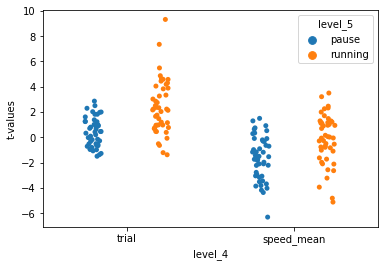

In [531]:
toplot = par_all.loc[(slice(None),slice(None),ti,y),:][['running','pause']].stack(level=0).reset_index(level=(-1,-2))
sns.stripplot(data=toplot,x='level_4',hue='level_5',y='t-values',dodge=True)

In [737]:
def plot_box_strip_multicategory(toplot,order0=None,order1=None,
                                 x='level_1',
                                y=0,
                                hue='level_2',
                                 fig=None,ax=None,
                                 pairs_iloc=[((0,0),(0,1)),((1,0),(1,1))]
                                ):
    # toplot: index: doesn't matter; ideally reset to one level, otherwise x and hue need to change
    # y: two levels, level0- x, level1-within x, sublevel
    # order0: the order for the level0 column category; order1:...
    # pairs_iloc: iloc for pairs of columns for doing wilcoxon signed rank sum test; iloc based on order, not necessarily the columns 
    
    
    level0=toplot.columns.get_level_values(0).unique()
    level1=toplot.columns.get_level_values(1).unique()
    dx = 0.2
    if ax is None:
        fig,ax=plt.subplots(figsize=(2,2))
    if order0 is None:
        order0 = level0
    if order1 is None:
        order1 = level1
    
    for xx,l0 in enumerate(order0):
        xs = np.array([xx-dx,xx+dx])
    
        for k,row in toplot[l0].iterrows():
            ax.plot(xs,row[order1].values,c='grey',alpha=0.3)
    
    toplot_sns=toplot.stack(level=(0,1)).reset_index(level=(-1,-2)) # long form

    sns.stripplot(data=toplot_sns,x=x,y=y,hue=hue,dodge=True,jitter=False,order=order0,hue_order=order1,s=3,ax=ax)
    ph.median_plot(data=toplot_sns,x=x,y=y,hue=hue,order=order0,hue_order=order1,ax=ax
               )
    

    handles, labels = ax.get_legend_handles_labels()
    try:
        ax.get_legend().set_visible(False)
    except:
        pass
    handles = handles[:2]
    labels = labels[:2]
    ax.legend(handles, labels,bbox_to_anchor=[1.7,1],frameon=False)
    sns.despine()
    ax.set(xlabel='',ylabel='Coef. (t-values)')
    ax.axhline(0,linestyle=':',c='k',alpha=0.5)

    from statannotations.Annotator import Annotator

    pairs = [
            (('trial','running'),('trial','pause')),
            (('speed_mean','running'),('speed_mean','pause')),
        ]

    pairs = [[(order0[il[0]],order1[il[1]]) for il in pi] for pi in pairs_iloc]

    annotator = Annotator(ax, pairs, data=toplot_sns, x=x,hue=hue, y=y,order=order0,hue_order=order1)
    annotator.configure(test='Wilcoxon', text_format='star')#, loc='outside')
    annotator.apply_and_annotate()

    pval = scipy.stats.wilcoxon(toplot).pvalue
    pval = pd.Series(pval,index=toplot.columns)

    eps=1e-10
    effect_sz = toplot.mean(axis=0) / (toplot.std(axis=0) + eps)
    test_res=pd.concat({'pval':pval,'effect_size':effect_sz},axis=1)

    # get paired wilcoxon test result
    pval_pair = {}
    effect_sz_pair = {}
    for pair in pairs:
        diff=toplot[pair[0]] - toplot[pair[1]]
        p = scipy.stats.wilcoxon(diff).pvalue
        pval_pair[tuple(pair)] = p
        effect_sz_pair[tuple(pair)] = diff.mean() / (diff.std()+eps)
    pval_pair = pd.Series(pval_pair)
    effect_sz_pair = pd.Series(effect_sz_pair)
    test_res_pair=pd.concat({'pval':pval_pair,'effect_size':effect_sz_pair},axis=1)
    
    return fig,ax,test_res,test_res_pair




p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

speed_mean_running vs. speed_mean_pause: Wilcoxon test (paired samples), P_val:6.545e-06 Stat=1.520e+02
trial_running vs. trial_pause: Wilcoxon test (paired samples), P_val:2.937e-06 Stat=1.400e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

speed_mean_running vs. speed_mean_pause: Wilcoxon test (paired samples), P_val:3.824e-03 Stat=2.800e+02
trial_running vs. trial_pause: Wilcoxon test (paired samples), P_val:1.505e-01 Stat=4.080e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

speed_mean_running vs. speed_mean_pause: Wilcoxon test (paire

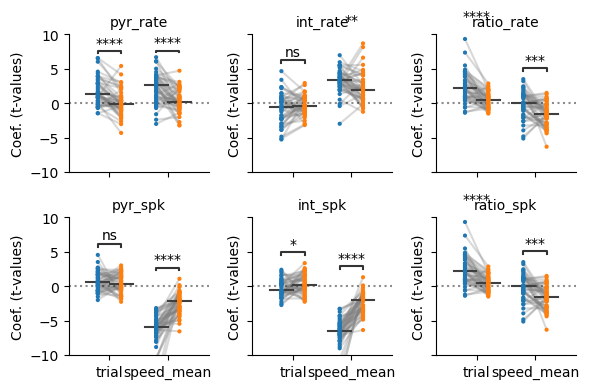

In [742]:
cell_type='ratio'
rate_spk='rate'
y=f'{cell_type}_{rate_spk}'

fig,axs=plt.subplots(2,3,figsize=(3*2,2*2),sharex=True,sharey=True)

for ii,rate_spk in enumerate(['rate','spk']):
    for jj,cell_type in enumerate(['pyr','int','ratio']):
        ax = axs[ii,jj]
        y=f'{cell_type}_{rate_spk}'
        toplot = par_all.loc[(slice(None),slice(None),ti,y),(['running','pause'],'t-values')].unstack(level=-1).droplevel(level=1,axis=1).swaplevel(0,1,axis=1)\
            .reset_index(drop=True)



        order0=None
        order1=None

        fig,ax,test_res,test_res_pair = plot_box_strip_multicategory(toplot,order0=None,order1=None,
                                         x='level_1',
                                        y=0,
                                        hue='level_2',
                                         fig=fig,ax=ax
                                        )
        ax.get_legend().set_visible(False)
        ax.set_ylim([-10,10])
        ax.set_title(y)
    
plt.tight_layout()



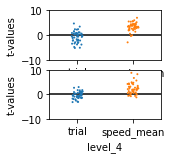

In [507]:
fig,axs=plt.subplots(2,1,figsize=(2,2))
for ii,ep in enumerate(['running','pause']):
    ax=axs[ii]
    toplot=par_all.loc[(slice(None),slice(None),ti,y),:][ep]['t-values'].reset_index(level=-1)
    sns.stripplot(data=toplot,x='level_4',y='t-values',ax=ax,s=2)
    ax.set_ylim([-10,10])
    ax.axhline(0,c='k')

In [479]:
pvals_to_combine=par_all.loc[(slice(None),slice(None),ti,y,'trial'),:]['pause']['P-values']

In [501]:
# tvals_to_combine=par_all.loc[(slice(None),slice(None),ti,y,'trial'),:]['pause']['t-values']
# tvals_to_combine=par_all.loc[(slice(None),slice(None),ti,y,'trial'),:]['running']['t-values']
tvals_to_combine=par_all.loc[(slice(None),slice(None),ti,y,'speed_mean'),:]['running']['t-values']
# tvals_to_combine=par_all.loc[(slice(None),slice(None),ti,y,'speed_mean'),:]['pause']['t-values']

In [502]:
tvals_to_combine.mean()/tvals_to_combine.std()

-0.07651251538038845

In [503]:
scipy.stats.wilcoxon(tvals_to_combine)

WilcoxonResult(statistic=538.0, pvalue=0.9827364126119278)

In [480]:
scipy.stats.combine_pvalues(pvals_to_combine)

SignificanceResult(statistic=115.39854647048125, pvalue=0.049942733530516405)

In [476]:
par_all.loc[(slice(None),slice(None),ti,y),:]['pause']['P-values'].reset_index(level=-1)

level_4  P-values
e13_16f1 e13_16f1_210302 0 ratio_spk       trial  0.295838
                           ratio_spk  speed_mean  0.012033
         e13_16f1_210312 0 ratio_spk       trial  0.231367
                           ratio_spk  speed_mean  0.374209
         e13_16f1_210314 0 ratio_spk       trial  0.744050
...                                          ...       ...
e16_3m2  e16_3m2_211210  0 ratio_spk  speed_mean  0.000356
         e16_3m2_211212  0 ratio_spk       trial  0.978174
                           ratio_spk  speed_mean  0.255346
         e16_3m2_211213  0 ratio_spk       trial  0.878653
                           ratio_spk  speed_mean  0.145136

[92 rows x 2 columns]

In [458]:
ti=0
y='ratio_spk'
par_all.loc[(slice(None),slice(None),ti,y),:]['running']['t-values']

e13_16f1  e13_16f1_210302  0  ratio_spk  trial         0.224770
                                         speed_mean   -0.340451
          e13_16f1_210312  0  ratio_spk  trial         0.224770
                                         speed_mean   -0.340451
          e13_16f1_210314  0  ratio_spk  trial         0.224770
                                                         ...   
e16_3m2   e16_3m2_211210   0  ratio_spk  speed_mean   -0.340451
          e16_3m2_211212   0  ratio_spk  trial         0.224770
                                         speed_mean   -0.340451
          e16_3m2_211213   0  ratio_spk  trial         0.224770
                                         speed_mean   -0.340451
Name: t-values, Length: 92, dtype: float64

In [443]:
res.tvalues

Intercept     53.014162
trial          0.224770
speed_mean    -0.340451
dtype: float64

In [442]:
ti = 0
y = 'ratio_spk'
par_all.loc[(slice(None),slice(None),ti,y),'running']

Coefficients  \
e13_16f1 e13_16f1_210302 0 ratio_spk Intercept       0.324514   
                                     trial           0.000212   
                                     speed_mean      0.005846   
         e13_16f1_210312 0 ratio_spk Intercept       0.332886   
                                     trial          -0.000683   
...                                                       ...   
e16_3m2  e16_3m2_211212  0 ratio_spk trial           0.000227   
                                     speed_mean      0.003686   
         e16_3m2_211213  0 ratio_spk Intercept       0.327014   
                                     trial           0.000138   
                                     speed_mean      0.003698   

                                                 Standard Errors  \
e13_16f1 e13_16f1_210302 0 ratio_spk Intercept          0.007025   
                                     trial              0.000596   
                                     speed_mean         0.003783   
         e13_16f1_210312 0 ratio_spk Intercept          0.006606   
                                     trial              0.000571   
...                                                          ...   
e16_3m2  e16_3m2_211212  0 ratio_spk trial              0.000511   
                                     speed_mean         0.008741   
         e16_3m2_211213  0 ratio_spk Intercept          0.005342   
                                     trial              0.000357   
                                     speed_mean         0.003186   

                                                     P-Values    CI_low  \
e13_16f1 e13_16f1_210302 0 ratio_spk Intercept   5.539019e-21  0.309810   
                                     trial       7.260782e-01 -0.001036   
                                     speed_mean  1.387809e-01 -0.002072   
         e13_16f1_210312 0 ratio_spk Intercept   7.879497e-21  0.319008   
                                     trial       2.469975e-01 -0.001881   
...                                                       ...       ...   
e16_3m2  e16_3m2_211212  0 ratio_spk trial       6.607857e-01 -0.000828   
                                     speed_mean  6.770033e-01 -0.014355   
         e16_3m2_211213  0 ratio_spk Intercept   7.145945e-28  0.315988   
                                     trial       7.031280e-01 -0.000599   
                                     speed_mean  2.572816e-01 -0.002879   

                                                  CI_high  
e13_16f1 e13_16f1_210302 0 ratio_spk Intercept   0.339218  
                                     trial       0.001460  
                                     speed_mean  0.013763  
         e13_16f1_210312 0 ratio_spk Intercept   0.346763  
                                     trial       0.000516  
...                                                   ...  
e16_3m2  e16_3m2_211212  0 ratio_spk trial       0.001282  
                                     speed_mean  0.021727  
         e16_3m2_211213  0 ratio_spk Intercept   0.338040  
                                     trial       0.000874  
                                     speed_mean  0.010274  

[138 rows x 5 columns]

In [400]:
ti= 0
to_predict_epoch = 'running'#'all'
to_predict = activity_all.loc[(ani,sess,ti),:]['original'][to_predict_epoch]
speed_one = speed_all.loc[(ani,sess,ti),:]['zscore'][to_predict_epoch]
speed_one.columns =['speed_'+k for k in speed_one.columns]


par_one,r2_one = fit_model_one_epoch_one_session(to_predict,speed_one)

/tmp/ipykernel_1190037/3557251486.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  to_predict = activity_all.loc[(ani,sess,ti),:]['original'][to_predict_epoch]


In [401]:
par_one

Coefficients  Standard Errors      P-Values  \
pyr_spk    Intercept    5084.850721       371.554949  7.859781e-13   
           trial          42.131213        24.806464  1.023626e-01   
           speed_mean  -1246.489852       221.605593  8.629889e-06   
int_spk    Intercept   15667.492436      1047.614926  1.158390e-13   
           trial         113.147830        69.942876  1.187926e-01   
           speed_mean  -3985.897539       624.826363  1.351254e-06   
ratio_spk  Intercept       0.327014         0.005342  7.145945e-28   
           trial           0.000138         0.000357  7.031280e-01   
           speed_mean      0.003698         0.003186  2.572816e-01   
pyr_rate   Intercept       6.498984         0.163034  1.910340e-23   
           trial           0.013564         0.010885  2.247436e-01   
           speed_mean      0.166046         0.097238  1.006118e-01   
int_rate   Intercept      19.867061         0.341064  2.330180e-27   
           trial           0.032880         0.022771  1.616786e-01   
           speed_mean      0.269835         0.203420  1.971619e-01   
ratio_rate Intercept       0.327014         0.005342  7.145945e-28   
           trial           0.000138         0.000357  7.031280e-01   
           speed_mean      0.003698         0.003186  2.572816e-01   

                             CI_low       CI_high  
pyr_spk    Intercept    4317.998997   5851.702446  
           trial          -9.066812     93.329238  
           speed_mean  -1703.861318   -789.118387  
int_spk    Intercept   13505.321498  17829.663374  
           trial         -31.207172    257.502831  
           speed_mean  -5275.475769  -2696.319308  
ratio_spk  Intercept       0.315988      0.338040  
           trial          -0.000599      0.000874  
           speed_mean     -0.002879      0.010274  
pyr_rate   Intercept       6.162498      6.835469  
           trial          -0.008901      0.036029  
           speed_mean     -0.034643      0.366735  
int_rate   Intercept      19.163139     20.570983  
           trial          -0.014116      0.079877  
           speed_mean     -0.150003      0.689674  
ratio_rate Intercept       0.315988      0.338040  
           trial          -0.000599      0.000874  
           speed_mean     -0.002879      0.010274

In [383]:
res.params

Intercept     0.333596
trial         0.000096
speed_mean   -0.001390
dtype: float64

In [379]:
y = 'ratio_rate'

model=smf.ols(f'{y}~trial + speed_mean',data=x_and_y)
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ratio_rate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.074
Method:                 Least Squares   F-statistic:                    0.1082
Date:                Thu, 04 Jan 2024   Prob (F-statistic):              0.898
Time:                        01:18:14   Log-Likelihood:                 73.604
No. Observations:                  27   AIC:                            -141.2
Df Residuals:                      24   BIC:                            -137.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3336      0.006     53.014      0.000       0.321       0.347
trial       9.622e-05      0.000      0.225      0.824      -0.001       0.001
speed_mean    -0.0014      0.004     -0.340      0.736      -0.010       0.007
==============================================================================
Omnibus:                        3.589   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                1.999
Skew:                           0.471   Prob(JB):                        0.368
Kurtosis:                       3.944   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [366]:
x_and_y

,trial,pyr_spk,int_spk,ratio_spk,pyr_rate,int_rate,ratio_rate,speed_mean,speed_std
0,0.0,7628.0,20439.0,0.373208,7.169173,19.209586,0.373208,0.453369,1.520013
1,1.0,14856.0,43962.0,0.337928,5.871937,17.376285,0.337928,-0.703105,-0.604555
2,2.0,7094.0,21206.0,0.334528,5.966358,17.835156,0.334528,0.092243,0.470452
3,3.0,6937.0,21296.0,0.325742,6.032174,18.518261,0.325742,0.309773,-0.315147
4,4.0,11731.0,34012.0,0.344908,4.391988,12.733808,0.344908,-1.774504,0.578887
5,5.0,15378.0,45685.0,0.336609,6.213333,18.458586,0.336609,-0.690034,-0.806486
6,6.0,7598.0,23087.0,0.329103,5.085676,15.453146,0.329103,-0.432679,0.646391
7,7.0,5041.0,15231.0,0.330970,6.332915,19.134422,0.330970,1.688016,1.766119
8,8.0,6607.0,21296.0,0.310246,6.256629,20.166667,0.310246,1.027594,0.084103
9,9.0,6086.0,19286.0,0.315566,6.191251,19.619532,0.315566,1.256009,0.675822


In [362]:
x_and_y

,trial,pyr_spk,int_spk,ratio_spk,pyr_rate,int_rate,ratio_rate,mean,std
0,0.0,7628.0,20439.0,0.373208,7.169173,19.209586,0.373208,0.453369,1.520013
1,1.0,14856.0,43962.0,0.337928,5.871937,17.376285,0.337928,-0.703105,-0.604555
2,2.0,7094.0,21206.0,0.334528,5.966358,17.835156,0.334528,0.092243,0.470452
3,3.0,6937.0,21296.0,0.325742,6.032174,18.518261,0.325742,0.309773,-0.315147
4,4.0,11731.0,34012.0,0.344908,4.391988,12.733808,0.344908,-1.774504,0.578887
5,5.0,15378.0,45685.0,0.336609,6.213333,18.458586,0.336609,-0.690034,-0.806486
6,6.0,7598.0,23087.0,0.329103,5.085676,15.453146,0.329103,-0.432679,0.646391
7,7.0,5041.0,15231.0,0.330970,6.332915,19.134422,0.330970,1.688016,1.766119
8,8.0,6607.0,21296.0,0.310246,6.256629,20.166667,0.310246,1.027594,0.084103
9,9.0,6086.0,19286.0,0.315566,6.191251,19.619532,0.315566,1.256009,0.675822


In [348]:
speed_all['all']

mean        std
                                  task_index trial                      
e13_26m1 e13_26m1_210913 original 0          0.0     9.816096   9.282622
                                             1.0     9.252614  11.568665
                                             2.0     8.611874   9.111552
                                             3.0    10.130865  11.531307
                                             4.0     8.895839  10.239701
...                                                       ...        ...
e14_2m3  e14_2m3_201118  zscore   0          19.0   -0.010577   0.247047
                                             20.0   -0.302328  -1.217286
                                             21.0   -0.561869   0.055147
                                             22.0    0.011120  -0.315691
                                             23.0   -0.181367   0.231118

[3128 rows x 2 columns]

In [217]:
toplot[k].reset_index(level=-1)

trial  pyr_spk
                         task_index                
e13_26m1 e13_26m1_210913 0             0.0  11160.0
                         0             1.0  10212.0
                         0             2.0  11187.0
                         0             3.0   9730.0
                         0             4.0  11184.0
...                                    ...      ...
e14_2m3  e14_2m3_201118  0            19.0   3985.0
                         0            20.0   4062.0
                         0            21.0   6062.0
                         0            22.0   3237.0
                         0            23.0   4506.0

[1250 rows x 2 columns]

In [226]:
toplot

pyr_spk  int_spk  ratio_spk  \
                         task_index trial                                
e13_26m1 e13_26m1_210913 0          0.0    11160.0  23480.0   0.475298   
                                    1.0    10212.0  23222.0   0.439755   
                                    2.0    11187.0  23715.0   0.471727   
                                    3.0     9730.0  21761.0   0.447130   
                                    4.0    11184.0  23224.0   0.481571   
...                                            ...      ...        ...   
e14_2m3  e14_2m3_201118  0          19.0    3985.0  11592.0   0.343772   
                                    20.0    4062.0  12654.0   0.321005   
                                    21.0    6062.0  17419.0   0.348011   
                                    22.0    3237.0  10061.0   0.321737   
                                    23.0    4506.0  12681.0   0.355335   

                                            pyr_rate   int_rate  ratio_rate  
                         task_index trial                                    
e13_26m1 e13_26m1_210913 0          0.0    16.291971  34.277372    0.475298  
                                    1.0    13.969904  31.767442    0.439755  
                                    2.0    14.700394  31.162943    0.471727  
                                    3.0    14.142442  31.629360    0.447130  
                                    4.0    14.412371  29.927835    0.481571  
...                                              ...        ...         ...  
e14_2m3  e14_2m3_201118  0          19.0    2.479776   7.213441    0.343772  
                                    20.0    2.457350   7.655172    0.321005  
                                    21.0    2.310213   6.638338    0.348011  
                                    22.0    2.417476   7.513816    0.321737  
                                    23.0    2.750916   7.741758    0.355335  

[1250 rows x 6 columns]

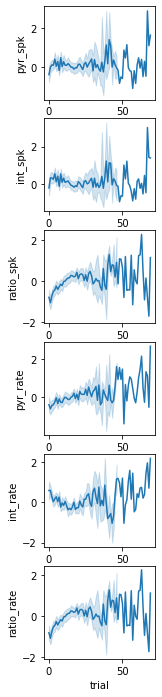

In [233]:
toplot = activity_all['zscore'].loc[(slice(None),slice(None),0),'running']
nplots=len(toplot.columns)
fig,axs=plt.subplots(nplots,1,figsize=(2,nplots*2))
for ii,k in enumerate(toplot.columns):
    ax=axs[ii]
    toplot[k].reset_index(level=-1)
    sns.lineplot(data=toplot[k].reset_index(),x='trial',y=k,ax=ax)


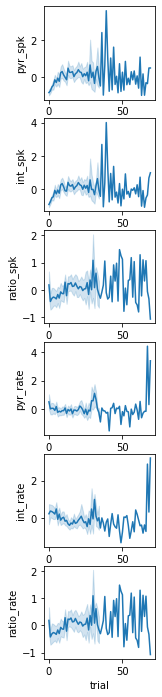

In [234]:
toplot = activity_all['zscore'].loc[(slice(None),slice(None),0),'pause']
nplots=len(toplot.columns)
fig,axs=plt.subplots(nplots,1,figsize=(2,nplots*2))
for ii,k in enumerate(toplot.columns):
    ax=axs[ii]
    toplot[k].reset_index(level=-1)
    sns.lineplot(data=toplot[k].reset_index(),x='trial',y=k,ax=ax)


<Axes: >

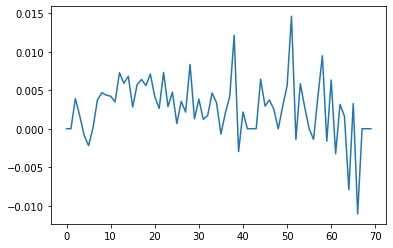

In [237]:
changes_df_all.mean(axis=0).plot()

In [239]:
changes_df_all==1

0      1      2      3      4   \
e13_26m1 e13_26m1_210913 0 0.0  3  0  False  False  False  False  False   
                                27 0  False  False  False  False  False   
                                29 0  False  False  False  False  False   
                                   1  False  False  False  False  False   
                                   2  False  False  False  False  False   
...                                     ...    ...    ...    ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  False   
                                32 0  False  False  False  False  False   
                                38 0  False  False  False  False  False   
                                47 0  False  False  False  False  False   
                                53 0  False  False  False  False  False   

                                         5      6      7      8      9   ...  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  False  False  False  False  False  ...   
                                27 0  False  False  False  False  False  ...   
                                29 0  False  False  False  False  False  ...   
                                   1  False  False  False  False  False  ...   
                                   2  False  False  False  False  False  ...   
...                                     ...    ...    ...    ...    ...  ...   
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  False  ...   
                                32 0  False  False  False  False  False  ...   
                                38 0  False  False  False  False  False  ...   
                                47 0  False  False  False  False  False  ...   
                                53 0  False  False  False  False  False  ...   

                                         60     61     62     63     64  \
e13_26m1 e13_26m1_210913 0 0.0  3  0  False  False  False  False  False   
                                27 0  False  False  False  False  False   
                                29 0  False  False  False  False  False   
                                   1  False  False  False  False  False   
                                   2  False  False  False  False  False   
...                                     ...    ...    ...    ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  False   
                                32 0  False  False  False  False  False   
                                38 0  False  False  False  False  False   
                                47 0  False  False  False  False  False   
                                53 0  False  False  False  False  False   

                                         65     66     67     68     69  
e13_26m1 e13_26m1_210913 0 0.0  3  0  False  False  False  False  False  
                                27 0  False  False  False  False  False  
                                29 0  False  False  False  False  False  
                                   1  False  False  False  False  False  
                                   2  False  False  False  False  False  
...                                     ...    ...    ...    ...    ...  
e14_2m3  e14_2m3_201118  0 both 30 0  False  False  False  False  False  
                                32 0  False  False  False  False  False  
                                38 0  False  False  False  False  False  
                                47 0  False  False  False  False  False  
                                53 0  False  False  False  False  False  

[14438 rows x 70 columns]

In [250]:
(off_df_all.sum(axis=0)+eps)

0      0.0
1      0.0
2     13.0
3     25.0
4     86.0
      ... 
65     1.0
66     8.0
67     9.0
68     0.0
69     0.0
Length: 70, dtype: object

<Axes: >

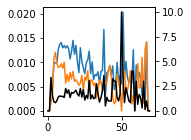

In [253]:
on_df_all=(changes_df_all==1).where(changes_df_all.notna(),np.nan)
off_df_all=(changes_df_all==-1).where(changes_df_all.notna(),np.nan)

eps=1e-10
ratio_all = on_df_all.sum(axis=0) / (off_df_all.sum(axis=0)+eps)
ratio_all[ratio_all>10] = 10
fig,ax=plt.subplots(figsize=(2,2))
on_df_all.mean(axis=0).plot(ax=ax)
off_df_all.mean(axis=0).plot(ax=ax)
ax2=ax.twinx()
ratio_all.plot(ax=ax2,c='k')




In [294]:
from scipy.ndimage import gaussian_filter1d

TypeError: gaussian_filter1d() missing 2 required positional arguments: 'input' and 'sigma'

In [298]:
off_mean

array([1.44681756e-06, 5.33904641e-05, 7.65109100e-04, 4.82607063e-03,
       1.42196130e-02, 1.89987519e-02, 1.12036730e-02, 6.50347624e-03,
       1.22519176e-02, 1.81183776e-02, 1.78139223e-02, 1.58239133e-02,
       1.19670437e-02, 7.50080359e-03, 4.57165567e-03, 3.34688300e-03,
       4.50174895e-03, 6.64525227e-03, 8.01923296e-03, 7.90595820e-03,
       6.38696331e-03, 3.59139176e-03])

In [331]:
gpb=on_df_all.groupby(level=(0,1,2))
on_off_corr_all = {}
sigma=0.1
for k,val in gpb:
    ani,sess,ti=k
    off_one=off_df_all.loc[k]
    on_mean=val.mean(axis=0).dropna()[4:]
    on_mean=gaussian_filter1d(on_mean,sigma)
    off_mean=off_one.mean(axis=0).dropna()[4:]
    off_mean=gaussian_filter1d(off_mean,sigma)
    corr=scipy.stats.pearsonr(on_mean,off_mean)
#     corr=pd.concat([on_mean,off_mean],axis=1).rcorr(method='spearman',stars=False)
    
    on_off_corr_all[k] = corr
# on_off_corr_all= pd.concat(on_off_corr_all,axis=0)
on_off_corr_all = pd.DataFrame(on_off_corr_all).T

/tmp/ipykernel_1190037/802522975.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  off_one=off_df_all.loc[k]


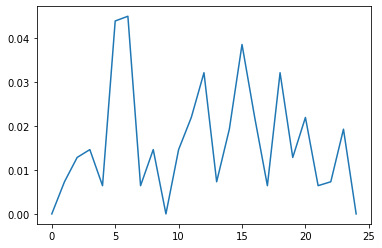

In [332]:
plt.plot(on_mean)

In [320]:
on_off_corr_all[1].round(2)

e13_16f1  e13_16f1_210302  0    0.01
          e13_16f1_210312  0    0.67
          e13_16f1_210314  0    0.01
          e13_16f1_210317  0    0.43
          e13_16f1_210319  0    0.14
          e13_16f1_210322  0    0.01
          e13_16f1_210328  0    0.39
          e13_16f1_210331  0    0.04
e13_26m1  e13_26m1_210913  0    0.00
          e13_26m1_211019  0    0.00
                           1    0.00
          e13_26m1_211116  0    0.01
                           1    0.00
          e13_26m1_211119  0    0.54
                           1    0.06
          e13_26m1_211124  0    0.02
e14_2m2   e14_2m2_201017   0    0.13
          e14_2m2_201019   0    0.14
e14_2m3   e14_2m3_201118   0    0.16
          e14_2m3_201121   0    0.34
          e14_2m3_201125   0    0.01
          e14_2m3_201129   0    0.04
          e14_2m3_201206   0    0.00
          e14_2m3_201208   0    0.06
e15_10m1  e15_10m1_200727  0    0.00
          e15_10m1_200803  0    0.15
          e15_10m1_200809  0    0.12
 

<Axes: >

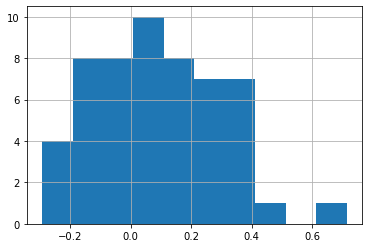

In [333]:
on_off_corr_all[0].hist()

<Axes: >

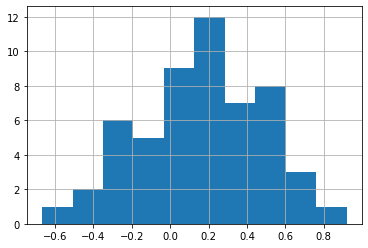

In [316]:
on_off_corr_all[0].hist()

<Axes: >

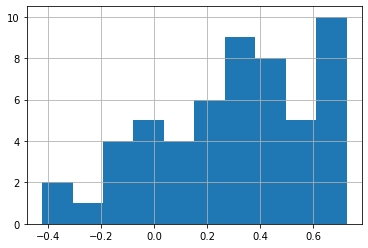

In [312]:
on_off_corr_all[0].hist()

<Axes: >

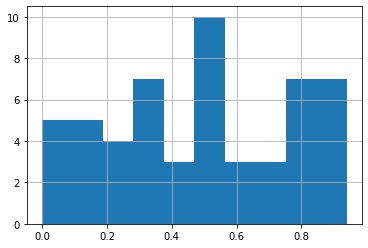

In [334]:
on_off_corr_all[1].hist()

<Axes: >

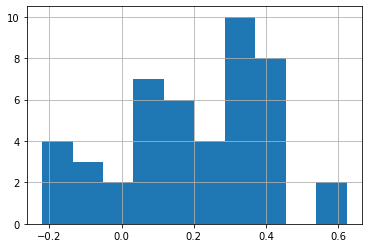

In [292]:
on_off_corr_all.loc[(slice(None),slice(None),0,1),0].astype(float).hist()

<Axes: >

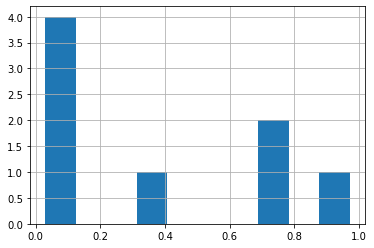

In [293]:
on_off_corr_all.loc[(slice(None),slice(None),1,0),1].astype(float).hist()

In [256]:
on_df_all.groupby(level=(0,1)).mean()

0    1         2         3         4         5   \
e13_16f1 e13_16f1_210302  0.0  0.0  0.005848  0.005848  0.032432  0.005848   
         e13_16f1_210312  0.0  0.0  0.008065  0.016129  0.000000  0.016129   
         e13_16f1_210314  0.0  0.0  0.015385  0.000000  0.007692  0.008000   
         e13_16f1_210317  0.0  0.0  0.000000  0.016260  0.000000  0.008130   
         e13_16f1_210319  0.0  0.0  0.009434  0.000000  0.028302  0.000000   
         e13_16f1_210322  0.0  0.0  0.000000  0.008333  0.000000  0.000000   
         e13_16f1_210328  0.0  0.0  0.016807  0.016667  0.000000  0.008333   
         e13_16f1_210331  0.0  0.0  0.005319  0.009346  0.000000  0.014019   
e13_26m1 e13_26m1_210913  0.0  0.0  0.000000  0.000000  0.013761  0.002294   
         e13_26m1_211019  0.0  0.0  0.004796  0.000000  0.009592  0.016771   
         e13_26m1_211116  0.0  0.0  0.003937  0.000000  0.035433  0.013216   
         e13_26m1_211119  0.0  0.0  0.007407  0.008163  0.014815  0.000000   
         e13_26m1_211124  0.0  0.0  0.006494  0.018750  0.000000  0.000000   
e14_2m2  e14_2m2_201017   0.0  0.0  0.000000  0.000000  0.010101  0.010753   
         e14_2m2_201019   0.0  0.0  0.000000  0.000000  0.008000  0.016949   
e14_2m3  e14_2m3_201118   0.0  0.0  0.043478  0.017857  0.014493  0.014493   
         e14_2m3_201121   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
         e14_2m3_201125   0.0  0.0  0.000000  0.000000  0.010309  0.021277   
         e14_2m3_201129   0.0  0.0  0.012195  0.000000  0.000000  0.038961   
         e14_2m3_201206   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
         e14_2m3_201208   0.0  0.0  0.000000  0.000000  0.000000  0.011905   
e15_10m1 e15_10m1_200727  0.0  0.0  0.012048  0.000000  0.036145  0.037975   
         e15_10m1_200803  0.0  0.0  0.000000  0.000000  0.031746  0.000000   
         e15_10m1_200809  0.0  0.0  0.000000  0.000000  0.030303  0.010101   
         e15_10m1_200812  0.0  0.0  0.000000  0.027523  0.000000  0.000000   
e15_13f1 e15_13f1_220117  0.0  0.0  0.012346  0.005714  0.012346  0.011429   
         e15_13f1_220118  0.0  0.0  0.000000  0.000000  0.013378  0.014545   
         e15_13f1_220119  0.0  0.0  0.010920  0.009631  0.001560  0.010920   
         e15_13f1_220120  0.0  0.0  0.002364  0.000000  0.004728  0.007389   
e15_9f1  e15_9f1_200715   0.0  0.0  0.017857  0.017241  0.017857  0.017241   
         e15_9f1_200720   0.0  0.0  0.000000  0.000000  0.012048  0.024096   
         e15_9f1_200723   0.0  0.0  0.010989  0.000000  0.000000  0.011628   
         e15_9f1_200729   0.0  0.0  0.000000  0.000000  0.000000  0.013986   
         e15_9f1_200802   0.0  0.0  0.000000  0.000000  0.000000  0.015152   
e16_1f1  e16_1f1_200918   0.0  0.0  0.000000  0.026316  0.000000  0.000000   
         e16_1f1_200919   0.0  0.0  0.000000  0.000000  0.000000  0.027027   
         e16_1f1_200920   0.0  0.0  0.012346  0.000000  0.000000  0.000000   
         e16_1f1_200923   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
         e16_1f1_201004   0.0  0.0  0.014925  0.013699  0.000000  0.013699   
e16_2m1  e16_2m1_201121   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
e16_3m1  e16_3m1_210119   0.0  0.0  0.005917  0.005714  0.017143  0.005917   
         e16_3m1_210201   0.0  0.0  0.005814  0.000000  0.011628  0.018750   
         e16_3m1_210203   0.0  0.0  0.005814  0.005814  0.005848  0.011628   
e16_3m2  e16_3m2_211210   0.0  0.0  0.005587  0.000000  0.000000  0.011173   
         e16_3m2_211212   0.0  0.0  0.004310  0.000000  0.021552  0.004000   
         e16_3m2_211213   0.0  0.0  0.002924  0.012384  0.014620  0.003096   

                                6         7         8         9   ...  \
e13_16f1 e13_16f1_210302  0.021622  0.016216  0.010811  0.023392  ...   
         e13_16f1_210312  0.024793  0.016129  0.008264  0.048387  ...   
         e13_16f1_210314  0.000000  0.000000  0.008000  0.007692  ...   
         e13_16f1_210317  0.007299  0.008130  0.007299  0.000000  ..

<Axes: >

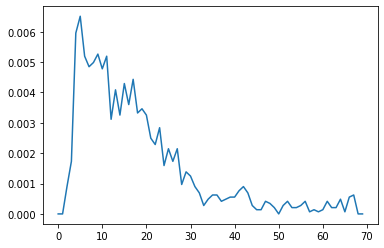

In [240]:
(changes_df_all==-1).mean(axis=0).plot()

In [200]:
activity_df = get_activity_per_trial(spk_beh_df,cell_cols_d)

In [201]:
activity_df_running_only = get_activity_per_trial(spk_beh_df.query('directed_locomotion>0.5'),cell_cols_d)

In [202]:
activity_df_nonrunning = get_activity_per_trial(spk_beh_df.query('directed_locomotion<0.5'),cell_cols_d)
activity_df_pause = get_activity_per_trial(spk_beh_df.query('pause_event>0.5'),cell_cols_d)

(<Figure size 144x216 with 5 Axes>,
 array([<Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>], dtype=object))

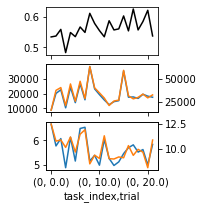

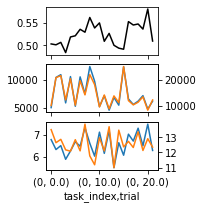

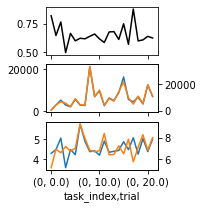

In [203]:
plot_ei_and_ratio(activity_df,ratio)
plot_ei_and_ratio(activity_df_running_only,ratio)
plot_ei_and_ratio(activity_df_pause,ratio)

(<Figure size 144x216 with 5 Axes>,
 array([<Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>], dtype=object))

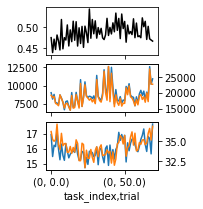

In [78]:
plot_ei_and_ratio(activity_df_running_only,ratio)

(<Figure size 144x216 with 5 Axes>,
 array([<Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>], dtype=object))

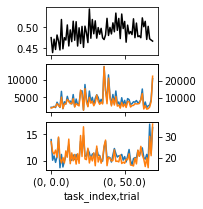

In [79]:
plot_ei_and_ratio(activity_df_nonrunning,ratio)

In [44]:
def plot_ei_and_ratio(pyr_activity,int_activity,ratio,c_d={'pyr':'C0','int':'C1','ratio':'k'},axs=None,fig=None):
    '''
    plot e and i as functions of trials; and seperately the ei ratio
    '''
    if axs is None:
        fig,axs=plt.subplots(2,1,sharex=True,figsize=(2,2),gridspec_kw={'height_ratios':[1,1]})
    ax=axs[0]
    ratio.plot(ax=ax,c=c_d['ratio'])
    ax=axs[1]
    pyr_activity.plot(ax=ax,c=c_d['pyr'])
    ax2=ax.twinx()
    int_activity.plot(ax=ax2,c=c_d['int'])
    
    return fig,axs

<Axes: xlabel='task_index,trial'>

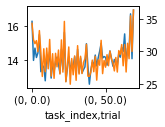

In [32]:
fig,ax=plt.subplots(figsize=(2,1.5))
pyr_rate.plot(ax=ax)
ax2=ax.twinx()
int_rate.plot(ax=ax2,c='C1')

(<Figure size 144x144 with 3 Axes>,
 array([<Axes: xlabel='task_index,trial'>,
        <Axes: xlabel='task_index,trial'>], dtype=object))

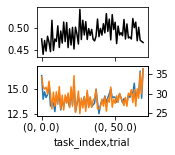

In [43]:
pyr_activity=pyr_rate
int_activity=int_rate
ratio=rate_ei
plot_ei_and_ratio(pyr_activity,int_activity,ratio)

<Axes: xlabel='task_index,trial'>

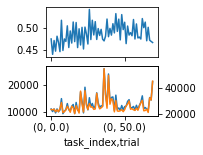

In [36]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(2,2),gridspec_kw={'height_ratios':[1,1]})
ax=axs[0]
spk_ei.plot(ax=ax)
ax=axs[1]
pyr_spk.plot(ax=ax)
ax2=ax.twinx()
int_spk.plot(ax=ax2,c='C1')


In [12]:
spk_beh_df

,1,2,3,4,5,6,7,8,9,10,...,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed,lin_binned,direction,v_raw
220,0,0,0,3,5,2,3,2,1,4,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
221,0,0,0,3,2,2,2,1,0,0,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
222,0,0,0,2,4,4,2,1,0,1,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
223,0,0,0,2,3,3,1,0,0,0,...,4.789330,True,False,True,False,False,False,0,NaN,NaN
224,0,0,0,1,2,3,1,1,1,0,...,4.816185,True,False,True,False,False,False,99,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64791,0,0,0,1,2,2,1,3,1,1,...,10.068745,True,False,False,False,True,False,97,NaN,NaN
64792,0,0,0,2,3,2,2,2,1,0,...,9.724899,True,False,False,False,True,False,97,NaN,NaN
64793,0,0,0,2,1,0,1,4,0,3,...,9.400999,True,False,False,False,True,False,96,NaN,NaN
64794,0,0,0,2,3,0,2,2,1,2,...,9.185424,True,False,False,False,True,False,96,NaN,NaN
